## Predicting Outcomes of Premier League Matches

Using a dataset of results from the 2023/24 Premier League season, our goal will be to train a model on this data and try and determine the outcome of a Premier League match, specifically if the team in question wins the game or fails to win the game.

In [1]:
import pandas as pd

# Load the dataset
matches = pd.read_csv('/Users/chris/Downloads/matches.csv', index_col = 0)
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
1,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3,0,Burnley,...,Match Report,NaN,17.0,8.0,13.9,0.0,0,0,2024,ManchesterCity
3,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1,0,Newcastle Utd,...,Match Report,NaN,14.0,4.0,17.9,0.0,0,0,2024,ManchesterCity
4,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2,1,Sheffield Utd,...,Match Report,NaN,29.0,9.0,17.3,2.0,0,1,2024,ManchesterCity
5,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,W,5,1,Fulham,...,Match Report,NaN,6.0,4.0,14.8,0.0,1,1,2024,ManchesterCity
6,2023-09-16,15:00,Premier League,Matchweek 5,Sat,Away,W,3,1,West Ham,...,Match Report,NaN,29.0,13.0,16.4,1.0,0,0,2024,ManchesterCity


In [2]:
# Number of rows
matches.shape[0]

760

In [3]:
# Missing values
matches.isna().sum()

Date              0
Time              0
Comp              0
Round             0
Day               0
Venue             0
Result            0
GF                0
GA                0
Opponent          0
xG                0
xGA               0
Poss              0
Attendance        0
Captain           0
Formation         0
Referee           0
Match Report      0
Notes           760
Sh                0
SoT               0
Dist              0
FK                0
PK                0
PKatt             0
Season            0
Team              0
dtype: int64

The Notes Column contains only null values so this can be dropped.

In [4]:
# Drop Notes columns
matches = matches.drop('Notes', axis = 1)
matches.columns

Index(['Date', 'Time', 'Comp', 'Round', 'Day', 'Venue', 'Result', 'GF', 'GA',
       'Opponent', 'xG', 'xGA', 'Poss', 'Attendance', 'Captain', 'Formation',
       'Referee', 'Match Report', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt',
       'Season', 'Team'],
      dtype='object')

There are some other columns that won't contribute to our analysis so we will drop them also.

In [5]:
matches = matches.drop(columns = ['Time', 'Comp', 'Attendance', 'Captain', 'Formation', 'Referee', 'Match Report', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt'], axis = 1)

In [6]:
# Column datatypes
matches.dtypes

Date         object
Round        object
Day          object
Venue        object
Result       object
GF            int64
GA            int64
Opponent     object
xG          float64
xGA         float64
Poss        float64
Season        int64
Team         object
dtype: object

As we will be using the Date column for calculations, it will need to be converted to a Datetime object to facilitate this.

In [7]:
# Convert Date column to Datetime
matches["Date"] = pd.to_datetime(matches["Date"])

We will now add columns to our table detailing The points a team received from a game and whether they won the game or not

In [8]:
# Add columns for points and wins
matches['Points'] = matches['Result'].map({'W': 3, 'D': 1, 'L': 0})
matches['win'] = matches['Result'].apply(lambda x: 1 if (x == 'W') else 0)

From the preview of the matches dataset above, we can see that the Team column has team names with spaces whereas the Opponent column does not have spaces. We will verify if the team names between both columns are consistent and if not, we will map values to remove inconsistencies.

In [9]:
matches['Team'].value_counts()

Team
ManchesterCity            38
Arsenal                   38
Burnley                   38
LutonTown                 38
NottinghamForest          38
Brentford                 38
Everton                   38
WolverhamptonWanderers    38
Fulham                    38
Bournemouth               38
BrightonandHoveAlbion     38
CrystalPalace             38
WestHamUnited             38
ManchesterUnited          38
NewcastleUnited           38
Chelsea                   38
TottenhamHotspur          38
AstonVilla                38
Liverpool                 38
SheffieldUnited           38
Name: count, dtype: int64

In [10]:
matches['Opponent'].value_counts()

Opponent
Burnley            38
Newcastle Utd      38
Brentford          38
Everton            38
Crystal Palace     38
Luton Town         38
Aston Villa        38
Tottenham          38
Liverpool          38
Chelsea            38
Bournemouth        38
Manchester Utd     38
Brighton           38
Arsenal            38
Wolves             38
Nott'ham Forest    38
West Ham           38
Fulham             38
Sheffield Utd      38
Manchester City    38
Name: count, dtype: int64

As suspected, some teams are stored as different string values between the two columns, so we will have to fix this.

In [11]:
# Update values to be consistent between columns
map_values = {"AstonVilla": "Aston Villa",
              "WestHamUnited": "West Ham",
              "TottenhamHotspur": "Tottenham",
              "SheffieldUnited": "Sheffield Utd",
              "NottinghamForest": "Nott'ham Forest",
              "NewcastleUnited": "Newcastle Utd",
              "ManchesterUnited": "Manchester Utd",
              "ManchesterCity": "Manchester City",
              "LutonTown": "Luton Town",
              "CrystalPalace": "Crystal Palace",
              "BrightonandHoveAlbion": "Brighton",
              "WolverhamptonWanderers": "Wolves",
              "Arsenal": "Arsenal",
              "Brentford": "Brentford",
              "Bournemouth": "Bournemouth",
              "Burnley": "Burnley",
              "Chelsea": "Chelsea",
              "Everton": "Everton",
              "Fulham": "Fulham",
              "Liverpool": "Liverpool"}
matches['Team'] = matches['Team'].map(map_values)
matches.head()

,Date,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Season,Team,Points,win
1,2023-08-11,Matchweek 1,Fri,Away,W,3,0,Burnley,1.9,0.3,65.0,2024,Manchester City,3,1
3,2023-08-19,Matchweek 2,Sat,Home,W,1,0,Newcastle Utd,1.0,0.3,59.0,2024,Manchester City,3,1
4,2023-08-27,Matchweek 3,Sun,Away,W,2,1,Sheffield Utd,3.5,0.7,79.0,2024,Manchester City,3,1
5,2023-09-02,Matchweek 4,Sat,Home,W,5,1,Fulham,2.2,1.4,68.0,2024,Manchester City,3,1
6,2023-09-16,Matchweek 5,Sat,Away,W,3,1,West Ham,3.6,0.9,68.0,2024,Manchester City,3,1


### Feature Engineering

In order to try and predict the outcome of a football match, we will need more information than is currently in the table. A very important factor to take into account is the form of each team coming into a match. We will calculate columns for these below, taking form to be the points obtained over the last 5 games per team.

In [12]:

matches_sorted = matches.sort_values(by=['Team', 'Date'])
def calculate_form(points_series):
    form = []
    for i in range(len(points_series)):
        if i <= 4:
            form_sum = points_series[:i].sum() / (i *3 if i != 0 else 1)  # Avoid division by zero
        else:
            form_sum = points_series[i-5:i].sum() / 15
        form.append(form_sum)
    return pd.Series(form, index=points_series.index)

matches_sorted['form_last_5'] = matches_sorted.groupby('Team')['Points'].transform(calculate_form)
matches_sorted['form_last_5']

1     0.000000
2     1.000000
3     1.000000
4     0.777778
5     0.833333
        ...   
40    0.133333
41    0.133333
42    0.266667
43    0.266667
44    0.200000
Name: form_last_5, Length: 760, dtype: float64

In [13]:
# Create a dictionary to map each team's date to their form_last_5
team_form_dict = matches_sorted.set_index(['Team', 'Date'])['form_last_5'].to_dict()

# Function to get opponent's form_last_5
def get_opponent_form(row): 
    opponent = row['Opponent']
    match_date = row['Date']
    return team_form_dict.get((opponent, match_date), None)

# Apply the function to get the opponent's form for each match
matches_sorted['opp_form_last_5'] = matches_sorted.apply(get_opponent_form, axis=1)
matches_sorted['opp_form_last_5'] = (matches_sorted['opp_form_last_5'])
matches_sorted.head(10)

,Date,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Season,Team,Points,win,form_last_5,opp_form_last_5
1,2023-08-12,Matchweek 1,Sat,Home,W,2,1,Nott'ham Forest,0.8,1.2,78.0,2024,Arsenal,3,1,0.000000,0.000000
2,2023-08-21,Matchweek 2,Mon,Away,W,1,0,Crystal Palace,2.0,1.0,53.0,2024,Arsenal,3,1,1.000000,1.000000
3,2023-08-26,Matchweek 3,Sat,Home,D,2,2,Fulham,3.2,0.6,71.0,2024,Arsenal,1,0,1.000000,0.500000
4,2023-09-03,Matchweek 4,Sun,Home,W,3,1,Manchester Utd,2.3,0.9,55.0,2024,Arsenal,3,1,0.777778,0.666667
5,2023-09-17,Matchweek 5,Sun,Away,W,1,0,Everton,1.0,0.3,74.0,2024,Arsenal,3,1,0.833333,0.083333
7,2023-09-24,Matchweek 6,Sun,Home,D,2,2,Tottenham,1.8,1.4,47.0,2024,Arsenal,1,0,0.866667,0.866667
9,2023-09-30,Matchweek 7,Sat,Away,W,4,0,Bournemouth,3.4,0.6,57.0,2024,Arsenal,3,1,0.733333,0.133333
11,2023-10-08,Matchweek 8,Sun,Home,W,1,0,Manchester City,0.4,0.5,49.0,2024,Arsenal,3,1,0.733333,0.800000
12,2023-10-21,Matchweek 9,Sat,Away,D,2,2,Chelsea,1.0,1.3,56.0,2024,Arsenal,1,0,0.866667,0.466667
14,2023-10-28,Matchweek 10,Sat,Home,W,5,0,Sheffield Utd,2.8,0.0,67.0,2024,Arsenal,3,1,0.733333,0.000000


In [14]:
## Verify if wins and losses are equal in Result column
matches_sorted['Result'].value_counts()

Result
W    298
L    298
D    164
Name: count, dtype: int64

In [15]:
# Verify win values
matches_sorted['win'].value_counts()

win
0    462
1    298
Name: count, dtype: int64

The number of non-wins is the number of losses added to the number of draws, as we would expect.

In order to use certain columns as predictors, such as Venue and the details of both teams involved in the match, these columns will need to be converted to a format that we can input to out model. We will convert the Venue column to binary depending on whether the Team played at home or not, and we will convert the Team and Opponent columns to categorical values in order to give a unique number code to each team in the league.

In [16]:
# Convert Venue, Team and Opponent to Categorical values
matches_sorted['Home'] = matches_sorted['Venue'].apply(lambda x: 1 if (x == 'Home') else 0)
matches_sorted['Team_Code'] = matches_sorted["Team"].astype("category").cat.codes
matches_sorted["Opp_Code"] = matches_sorted["Opponent"].astype("category").cat.codes

Another important factor to take into consideration is whether a team involved in a Premier League fixture also took part in a European fixture midweek prior to the match. This can play a big factor in the preparaton of teams for matches, especially if a team had to travel abroad to another country for their match. Below are the dates that teams played in European fixtures, and we will use these to implement a function recording whether a team had a European game prior to their game at the weekend.

In [17]:
# European fixture dates for each team
european_fixtures = {
    "Manchester City": ["2023-09-19", "2023-10-04", "2023-10-25", "2023-11-07", "2023-11-28", 
                       "2023-12-13", "2024-02-13", "2024-03-06", "2024-04-09", "2024-04-17"],
    "Arsenal": ["2023-09-20", "2023-10-03", "2023-10-24", "2023-11-08", "2023-11-29", 
                "2023-12-12", "2024-02-21", "2024-03-12", "2024-04-09", "2024-04-17"],
    "Manchester Utd": ["2023-09-20", "2023-10-03", "2023-10-24", "2023-11-08", "2023-11-29", 
                      "2023-12-12"],
    "Newcastle Utd": ["2023-09-19", "2023-10-04", "2023-10-25", "2023-11-07", "2023-11-28", 
                     "2023-12-13"],
    "Liverpool": ["2023-09-21", "2023-10-05", "2023-10-26", "2023-11-09", "2023-11-30", 
                  "2023-12-14", "2024-03-07", "2024-03-14", "2024-04-11", "2024-04-18"],
    "West Ham": ["2023-09-21", "2023-10-05", "2023-10-26", "2023-11-09", "2023-11-30", 
                "2023-12-14", "2024-03-07", "2024-03-14", "2024-04-11", "2024-04-18"],
    "Brighton": ["2023-09-21", "2023-10-05", "2023-10-26", "2023-11-09", "2023-11-30", 
                 "2023-12-14", "2024-03-07", "2024-03-14"],
    "Aston Villa": ["2023-09-21", "2023-10-05", "2023-10-26", "2023-11-09", "2023-11-30", 
                   "2023-12-14", "2024-03-07", "2024-03-14", "2024-04-11", "2024-04-18", 
                   "2024-05-02", "2024-05-09"]}

We will use a time period of 4 days to define if a team had a European match 4 days before their current match. Even though teams could play in Europe on a Tuesday and play in the Premier League on a Sunday/Monday for example, this should be enough recovery time for the extra fixture to not play a factor.

In [18]:
# Convert European fixture dates to datetime
for team, dates in european_fixtures.items():
    european_fixtures[team] = pd.to_datetime(dates)
    
# Sort matches by date
matches_sorted['Date'] = pd.to_datetime(matches_sorted['Date'])
    
# Function to check if a team had a European game within 4 days before the match
def had_euro_game(team, match_date):
    if team in european_fixtures:
        for fixture_date in european_fixtures[team]:
            if 0 < (match_date - fixture_date).days <= 4:
                return True
    return False

In [19]:
# Apply the function to each row for team and opponent
matches_sorted['team_had_euro_game'] = matches_sorted.apply(lambda row: had_euro_game(row['Team'], row['Date']), axis=1)
matches_sorted['opp_had_euro_game'] = matches_sorted.apply(lambda row: had_euro_game(row['Opponent'], row['Date']), axis=1)

In [20]:
# Check implementation of function using an example team
matches_sorted[matches_sorted['Team'] == 'Aston Villa']

,Date,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,...,Team,Points,win,form_last_5,opp_form_last_5,Home,Team_Code,Opp_Code,team_had_euro_game,opp_had_euro_game
0,2023-08-12,Matchweek 1,Sat,Away,L,1,5,Newcastle Utd,1.8,3.3,...,Aston Villa,0,0,0.000000,0.000000,0,1,14,False,False
1,2023-08-20,Matchweek 2,Sun,Home,W,4,0,Everton,2.9,0.6,...,Aston Villa,3,1,0.000000,0.000000,1,1,8,False,False
3,2023-08-27,Matchweek 3,Sun,Away,W,3,1,Burnley,2.5,0.7,...,Aston Villa,3,1,0.500000,0.000000,0,1,5,False,False
5,2023-09-03,Matchweek 4,Sun,Away,L,0,3,Liverpool,0.7,2.5,...,Aston Villa,0,0,0.666667,0.777778,0,1,10,False,False
6,2023-09-16,Matchweek 5,Sat,Home,W,3,1,Crystal Palace,3.0,1.2,...,Aston Villa,3,1,0.500000,0.583333,1,1,7,False,False
8,2023-09-24,Matchweek 6,Sun,Away,W,1,0,Chelsea,1.0,1.3,...,Aston Villa,3,1,0.600000,0.333333,0,1,6,True,False
10,2023-09-30,Matchweek 7,Sat,Home,W,6,1,Brighton,1.6,1.7,...,Aston Villa,3,1,0.800000,0.800000,1,1,4,False,False
12,2023-10-08,Matchweek 8,Sun,Away,D,1,1,Wolves,1.6,1.7,...,Aston Villa,1,0,0.800000,0.466667,0,1,19,True,False
13,2023-10-22,Matchweek 9,Sun,Home,W,4,1,West Ham,1.9,1.1,...,Aston Villa,3,1,0.666667,0.466667,1,1,18,False,False
15,2023-10-29,Matchweek 10,Sun,Home,W,3,1,Luton Town,2.3,0.5,...,Aston Villa,3,1,0.866667,0.333333,1,1,11,True,False


It is worth considering in general whether a team had a match 4 days or less prior to their current match eg. a Premier League match on a Wednesday and a Premier League match on a Saturday. We will avoid calculating this for now, as in most case this will be universal for all teams in the league, if there is a full fixture slate midweek for example. The only time this may play a part is if a team has a fixture rearranged from earlier in the season and they have to play two games in quick succession while their opponent does not.

### Building the model

We will now build an initial model to predict if a team wins a match or not.
We set our Target variable to the `win` column.
For predictors, we are initially interested in the teams that played in a match, their form leading up to the match, the home stadium that the game was played in, and whether either team had a european match prior to the match. \

Therefore our predictors will be `Team_Code`, `Opponent_Code`, `form_last_5`, `opp_form_last_5`, `venue_code`, `team_europe_midweek`, `opp_europe_midweek`.

Let's start by building a Random Forest model.

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, oob_score = True, random_state=33)

In [23]:
# Split into train and test sets ensuring test set matches all take place after training set matches 
train = matches_sorted[matches_sorted["Date"] < '2024-01-01']
test = matches_sorted[matches_sorted["Date"] > '2024-01-01']

In [24]:
# Define predictors and target 
predictors = ["Home", "Opp_Code", "Team_Code", "form_last_5", "opp_form_last_5", "team_had_euro_game", "opp_had_euro_game"]
target = 'win'

X_train = train[predictors]
y_train = train[target]

# Fit the model on training and test sets
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=50, oob_score=True,
                       random_state=33)

In [25]:
# Calculate predicted values from test set
preds = rf.predict(test[predictors])

In [26]:
from sklearn.metrics import accuracy_score
# Calculate error of model
error = accuracy_score(test[target], preds)
error

0.6693989071038251

In [27]:
combined = pd.DataFrame(dict(actual=test[target], predicted=preds))

In [28]:
# Calculate confusion matrix
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,180,49
1,72,65


The model correctly predicted a win 65 times, but falsely predicted a win 49 times. This is not bad but we can hope to improve it. It failed to predict a win 72 times, and correctly predicted a draw/loss 180. We would expect this last value to be higher because it takes into account 2 types of result, making it easier to predict correctly.

In [29]:
from sklearn.metrics import precision_score

# Calculate precision score
precision_score(test[target], preds)

0.5701754385964912

In [30]:
print("Out Of Bag Score:", round(rf.oob_score_, 3))

Out Of Bag Score: 0.587


### Adjusting the model

To try and improve the accuracy of our model, we will start by increasing the size of the training set to give the model more data to learn from.

In [31]:

train2 = matches_sorted[matches_sorted["Date"] < '2024-03-10']
test2 = matches_sorted[matches_sorted["Date"] > '2024-03-10']

X_train2 = train2[predictors]
y_train2 = train2[target]
X_test2 = test2[predictors]
y_test2 = test2[target]

In [32]:
rf.fit(X_train2, y_train2)


RandomForestClassifier(min_samples_split=10, n_estimators=50, oob_score=True,
                       random_state=33)

In [33]:
preds2 = rf.predict(X_test2)

In [34]:
error2 = accuracy_score(y_test2, preds2)
error2

0.6796116504854369

In [35]:
combined2 = pd.DataFrame(dict(actual=y_test2, predicted=preds2))

In [36]:
pd.crosstab(index=combined2["actual"], columns=combined2["predicted"])

predicted,0,1
actual,,
0,105,23
1,43,35


In [37]:
precision_score(y_test2, preds2)

0.603448275862069

In [38]:
print("Out Of Bag Score:", round(rf.oob_score_, 3))

Out Of Bag Score: 0.615


The model resulted in a higher accuracy and precision scores, so updating the train/test sizes helped.

We will now try some other models to compare accuracy values and determine the best fit for our data.

#### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(X_train2, y_train2)

LogisticRegression()

In [40]:
acc = LR_model.score(X_train2, y_train2)

predictions = LR_model.predict(X_train2)
tp = sum((predictions == 1) & (y_train2 == 1))
fp = sum((predictions == 1) & (y_train2 == 0))
tn = sum((predictions == 0) & (y_train2 == 0))
fn = sum((predictions == 0) & (y_train2 == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Training Accuracy: ", acc)
print("Training Sensitivity: ", sens)
print("Training Specificity: ", spec)

Training Accuracy:  0.63003663003663
Training Sensitivity:  0.3486238532110092
Training Specificity:  0.8170731707317073


In [41]:
# Checking the various metrics for the model (test set)
acc = LR_model.score(X_test2, y_test2)

predictions = LR_model.predict(X_test2)
tp = sum((predictions == 1) & (y_test2 == 1))
fp = sum((predictions == 1) & (y_test2 == 0))
tn = sum((predictions == 0) & (y_test2 == 0))
fn = sum((predictions == 0) & (y_test2 == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Test Accuracy: ", acc)
print("Test Sensitivity: ", sens)
print("Test Specificity: ", spec)

Test Accuracy:  0.6893203883495146
Test Sensitivity:  0.4358974358974359
Test Specificity:  0.84375


In [42]:
precision_score(y_test2, predictions)

0.6296296296296297

This model has a slightly higher test accuracy of 0.690 compared to the value of 0.670 of the random forest model.

#### KNN Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train2, y_train2)
accuracy = knn.score(X_test2, y_test2)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 56.31


We can use GridSearch to try and find the optimal hyperparameters for the KNN model.

In [44]:
from sklearn.model_selection import GridSearchCV
grid_params = {"n_neighbors": range(1, 5),
                "metric": ["minkowski", "manhattan"]
              }
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train2, y_train2)

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 5)},
             scoring='accuracy')

In [45]:
knn_grid.best_score_*100, knn_grid.best_params_

(61.179316096747286, {'metric': 'minkowski', 'n_neighbors': 2})

In [46]:
predictions = knn_grid.best_estimator_.predict(X_test2)
accuracy = accuracy_score(y_test2, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 61.65


In [47]:
precision_score(y_test2, predictions)

0.48936170212765956

The parameters found through grid search improved the model.

#### Tensorflow

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# define model
tf.random.set_seed(33)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [50]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [51]:
model.fit(X_train2, y_train2, epochs = 100)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3737 - loss: 0.8765
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3631 - loss: 0.7286 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4341 - loss: 0.7027 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4946 - loss: 0.6940
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5587 - loss: 0.6897 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 0.6860 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6226 - loss: 0.6825 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6293 - loss: 0.6796 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6275 - loss: 0.6770 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6241 - loss: 0.6746 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6339 - loss: 0.6717 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

The accuracy and loss both improved over 100 epochs.

In [52]:
model.evaluate(X_train2, y_train2)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7102 - loss: 0.5536  


[0.579980194568634, 0.6831501722335815]

71% accuracy on the training set.

In [53]:
model.evaluate(X_test2, y_test2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6732 - loss: 0.7435 


[0.6701581478118896, 0.6844660043716431]

67% accuracy on the test set.

## Initial conclusions

Random Forest: test accuracy: 0.680, precision score: 0.603 \
Logistic Regression: test accuracy: 0.689, precision score: 0.630 \
KNN Classifier: test accuracy: 0.617, precision score: 0.480 \
Tensorflow: test accuracy: 0.655

The most accurate model was the Logistic Regression model. To continue, we could implement this model using different features and by optimising the hyperparameters to try and achieve better results.

### Next Steps

We could define new feature such as average xG and average xGA over the past 5 games per team to see if these have a strong impact on the target column.

In [54]:
# Function to calculate average values across last 5 games
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [55]:
cols = ["GF", "GA", "xG", "xGA"]
new_cols = [f"avg_{c}_last_5" for c in cols]

In [56]:
# Update dataframe with avg last 5 columns for GF, GA, xG and xGA
matches_sorted = matches_sorted.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_sorted

Date         Round  Day Venue Result  GF  GA  \
Team                                                            
Arsenal 7  2023-09-24   Matchweek 6  Sun  Home      D   2   2   
        9  2023-09-30   Matchweek 7  Sat  Away      W   4   0   
        11 2023-10-08   Matchweek 8  Sun  Home      W   1   0   
        12 2023-10-21   Matchweek 9  Sat  Away      D   2   2   
        14 2023-10-28  Matchweek 10  Sat  Home      W   5   0   
...               ...           ...  ...   ...    ...  ..  ..   
Wolves  40 2024-04-24  Matchweek 29  Wed  Home      L   0   1   
        41 2024-04-27  Matchweek 35  Sat  Home      W   2   1   
        42 2024-05-04  Matchweek 36  Sat  Away      L   1   5   
        43 2024-05-11  Matchweek 37  Sat  Home      L   1   3   
        44 2024-05-19  Matchweek 38  Sun  Away      L   0   2   

                   Opponent   xG  xGA  ...  opp_form_last_5  Home Team_Code  \
Team                                   ...                                    
Arsenal 7         Tottenham  1.8  1.4  ...         0.866667     1         0   
        9       Bournemouth  3.4  0.6  ...         0.133333     0         0   
        11  Manchester City  0.4  0.5  ...         0.800000     1         0   
        12          Chelsea  1.0  1.3  ...         0.466667     0         0   
        14    Sheffield Utd  2.8  0.0  ...         0.000000     1         0   
...                     ...  ...  ...  ...              ...   ...       ...   
Wolves  40      Bournemouth  0.5  1.9  ...         0.466667     1        19   
        41       Luton Town  1.2  0.6  ...         0.200000     1        19   
        42  Manchester City  0.3  3.7  ...         1.000000     0        19   
        43   Crystal Palace  1.6  2.6  ...         0.866667     1        19   
        44        Liverpool  0.5  4.5  ...         0.533333     0        19   

            Opp_Code  team_had_euro_game  opp_had_euro_game  avg_GF_last_5  \
Team                                                                         
Arsenal 7         17                True              False            1.8   
        9          2               False              False            1.8   
        11        12               False               True            2.4   
        12         6               False              False            2.2   
        14        16                True              False            2.0   
...              ...                 ...                ...            ...   
Wolves  40         2               False              False            0.8   
        41        11               False              False            0.8   
        42        12               False              False            1.0   
        43         7               False              False            1.0   
        44        10               False              False            0.8   

            avg_GA_last_5  avg_xG_last_5  avg_xGA_last_5  
Team                                                      
Arsenal 7             0.8           1.86            0.80  
        9             1.0           2.06            0.84  
        11            1.0           2.34            0.76  
        12            0.6           1.78            0.74  
        14            0.8           1.52            0.82  
...                   ...            ...             ...  
Wolves  40            1.8           1.02            1.32  
        41            1.6           0.82            1.50  
        42            1.6           0.88            1.36  
        43            2.2           0.64            1.86  
        44            2.4           0.76            2.00  

[660 rows x 26 columns]

We can check the correlations each column has with the target column to determine any additional optimal features.

<Axes: >

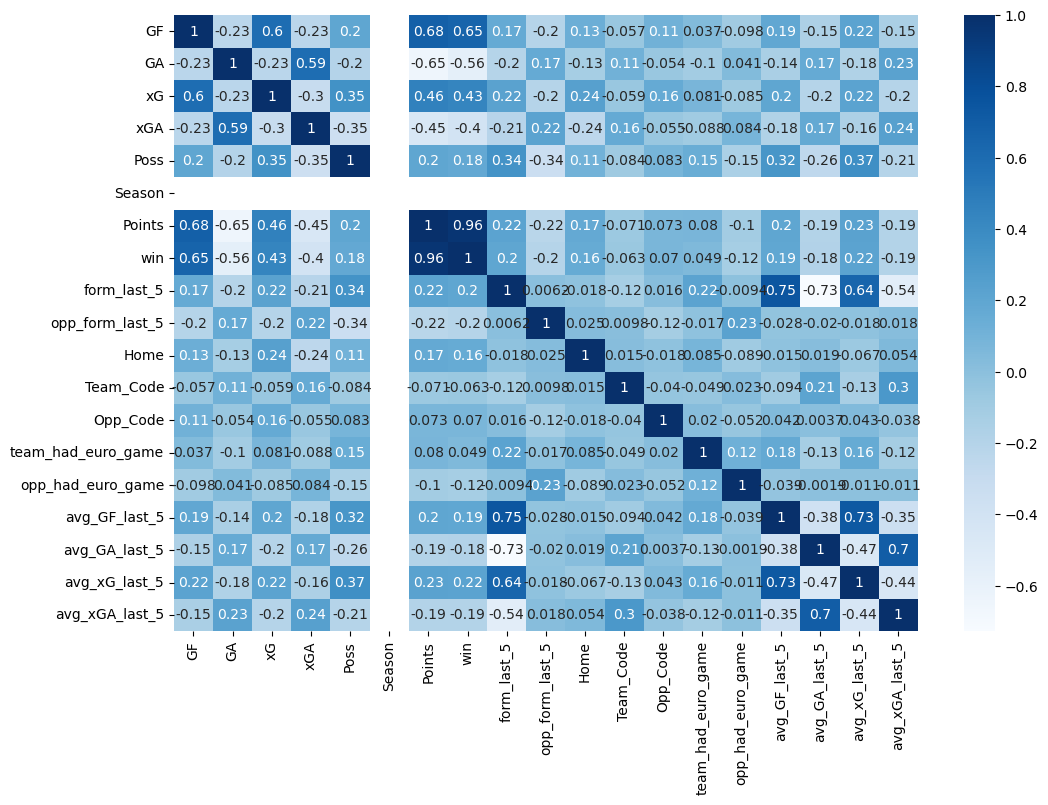

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
correlations = matches_sorted.corr(numeric_only = True)
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

Our newly created columns have good correlation with our target column, so adding these to our model may improve accuracy.

Our next steps could be obtaining injury and suspension records to determine the number of missing players for teams on the day of each game, specifically if any key players were missing for a team. We are also interested in the historical head to head record between teams, and this can be obtained by adding data from previous seasons into our analysis and using this to calculate head to head records between teams.